# Исследование тарифных планов федерального оператора сотовой связи. <a class="tocSkip"> 

 Клиентам сотовой связи предлагается два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, необходимо выяснить, какой тариф приносит больше денег.

## Описание проекта. <a class="tocSkip"> 

По представленным данным необходимо провести предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 


###### Описание тарифов:


**- Тариф «Смарт»**


1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.


**- Тариф «Ультра»**

1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.


Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

###### Цель исследования :
Проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

###### Ход исследования

Данные о поведении пользователей (статистика о платёжеспособности клиентов)- в файлах: 

    •	/datasets/calls.csv 
    •	/datasets/internet.csv
    •	/datasets/messages.csv
    •	/datasets/tariffs.csv
    •	/datasets/users.csv

О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных.

Проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе предобработки поищем возможность исправить самые критичные ошибки данных.

Таким образом, исследование пройдёт в три этапа:

1. Обзор данных.


2. Предобработка данных.


3. Расчет дополнительных параметров, необходимых для исследования:


      •	количество сделанных звонков и израсходованных минут разговора по месяцам;
      •	количество отправленных сообщений по месяцам;
      •	объем израсходованного интернет-трафика по месяцам;
      •	помесячную выручку с каждого пользователя (вычтете бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).


4. Исследовательский анализ данных. 
     
    •	Описание поведения клиентов оператора, исходя из выборки.       
        
    •	Проверка гипотез: 
    
         - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
         - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

  

# Обзор данных.

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import numpy as np
from scipy import stats as st

warnings.filterwarnings('ignore')

#открываем и сохраняем как датафреймы файлы с данными:
try:
    # personal path
    calls = pd.read_csv('calls.csv') 
    internet = pd.read_csv('internet.csv') 
    messages = pd.read_csv('messages.csv') 
    tariffs = pd.read_csv('tariffs.csv') 
    users = pd.read_csv('users.csv') 
    
except:
    # Yandex path
    calls = pd.read_csv('/datasets/calls.csv') 
    internet = pd.read_csv('/datasets/internet.csv') 
    messages = pd.read_csv('/datasets/messages.csv') 
    tariffs = pd.read_csv('/datasets/tariffs.csv') 
    users = pd.read_csv('/datasets/users.csv')
    

Для удобства зададим несколько функций:

In [2]:
#функция для вывода состава столбцов
def describe_cols(df_data):
    df = df_data
    values = pd.DataFrame()
    
    for col in df.columns:
        values[col] = [df[col].unique(), df[col].dtypes, df[col].nunique()]
        
    return values.transpose().sort_values(by=1, ascending=True).rename(
        {0: 'Значения', 1: 'тип данных', 2: 'Кол-во уникальных значений'}, axis=1)


#функция для вывода пустых значений и их доли в столбцах датафрейма
def nan_values(df_data):
    df = df_data
    count_missing = df.isna().sum()
    percent_missing = round(df.isna().sum() * 100 / len(df), 2)
    
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'num_missing': count_missing,
                                     'percent_missing': percent_missing})
    
    return missing_value_df


#функция для вывода информации о файле
def df_info (df_data):
    print('Количество строк файла:', len(df_data))
    print()
    print('Информация о содержимом файла:')
    display(describe_cols(df_data))
    print()
    print('Информация о пропусках данных:')
    display(nan_values(df_data))
    print()
    print('Первые пять строк таблицы:')
    display(df_data.head())


Рассмотрим подробнее содержимое файлов:

## Файл `calls`:

In [3]:
#информация о содержимом 
df_info(calls)    

Количество строк файла: 202607

Информация о содержимом файла:


,Значения,тип данных,Кол-во уникальных значений
user_id,"[1000, 1001, 1002, 1003, 1004, 1005, 1006, 100...",int64,492
duration,"[0.0, 2.85, 13.8, 5.18, 18.31, 18.44, 5.03, 18...",float64,2871
id,"[1000_0, 1000_1, 1000_2, 1000_3, 1000_4, 1000_...",object,202607
call_date,"[2018-07-25, 2018-08-17, 2018-06-11, 2018-09-2...",object,365



Информация о пропусках данных:


,column_name,num_missing,percent_missing
id,id,0,0.0
call_date,call_date,0,0.0
duration,duration,0,0.0
user_id,user_id,0,0.0



Первые пять строк таблицы:


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
# проверим данные на логические ошибки ("здравый смысл"):
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


**Вывод**

В файле `calls` - данные о звонках клиентов.


Содержание данных:

- `user_id`	- id пользователя 
 - `id` - id звонка пользователя
 - `call_date` - дата звонка
 - `duration` - продолжительность звонка 
 
Файл содержит 202607 строк, пропуски отсутствуют. 


**Необходимые изменения:**

- необходимо заменить формат столбца `call_date` с object на datetime 

## Файл `internet`:

In [5]:
#информация о содержимом 
df_info(internet)    

Количество строк файла: 149396

Информация о содержимом файла:


,Значения,тип данных,Кол-во уникальных значений
Unnamed: 0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",int64,149396
user_id,"[1000, 1001, 1002, 1003, 1004, 1005, 1006, 100...",int64,497
mb_used,"[112.95, 1052.81, 1197.26, 550.27, 302.56, 399...",float64,70003
id,"[1000_0, 1000_1, 1000_2, 1000_3, 1000_4, 1000_...",object,149396
session_date,"[2018-11-25, 2018-09-07, 2018-06-25, 2018-08-2...",object,365



Информация о пропусках данных:


,column_name,num_missing,percent_missing
Unnamed: 0,Unnamed: 0,0,0.0
id,id,0,0.0
mb_used,mb_used,0,0.0
session_date,session_date,0,0.0
user_id,user_id,0,0.0



Первые пять строк таблицы:


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
# проверим данные на логические ошибки ("здравый смысл"):
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


**Вывод**

В файле `internet` - данные об интернет-трафике клиентов.


Таблица содержит 149396 строк, пропуски отсутствуют.

Содержание данных:

- `user_id` - id пользователя
- `id` - id интернет-сессии пользователя 
- `session_date` - дата интернет-сессии
- `mb_used` - данные об использованном во время сессии трафике в Мб
- `Unnamed` - порядковый номер записи, повторяющий индекс датафрейма

**Необходимые изменения:**

- необходимо заменить формат столбца `session_date` с object на datetime 


## Файл `messages`:

In [7]:
#информация о содержимом 
df_info(messages)    

Количество строк файла: 123036

Информация о содержимом файла:


,Значения,тип данных,Кол-во уникальных значений
user_id,"[1000, 1002, 1003, 1004, 1005, 1007, 1008, 100...",int64,426
id,"[1000_0, 1000_1, 1000_2, 1000_3, 1000_4, 1000_...",object,123036
message_date,"[2018-06-27, 2018-10-08, 2018-08-04, 2018-06-1...",object,364



Информация о пропусках данных:


,column_name,num_missing,percent_missing
id,id,0,0.0
message_date,message_date,0,0.0
user_id,user_id,0,0.0



Первые пять строк таблицы:


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


**Вывод**

В файле `messages` - данные о звонках клиентов.
Таблица содержит 123036 строк, пропуски отсутствуют.

Содержание данных:

- `user_id` - id пользователя
- `id` - id смс-сообщения
- `message_date` - дата смс-сообщения

**Необходимые изменения:**

- необходимо заменить формат столбца `message_date` с object на datetime 


## Файл `tariffs`:

In [8]:
#информация о содержимом 
df_info(tariffs)    

Количество строк файла: 2

Информация о содержимом файла:


,Значения,тип данных,Кол-во уникальных значений
messages_included,"[50, 1000]",int64,2
mb_per_month_included,"[15360, 30720]",int64,2
minutes_included,"[500, 3000]",int64,2
rub_monthly_fee,"[550, 1950]",int64,2
rub_per_gb,"[200, 150]",int64,2
rub_per_message,"[3, 1]",int64,2
rub_per_minute,"[3, 1]",int64,2
tariff_name,"[smart, ultra]",object,2



Информация о пропусках данных:


,column_name,num_missing,percent_missing
messages_included,messages_included,0,0.0
mb_per_month_included,mb_per_month_included,0,0.0
minutes_included,minutes_included,0,0.0
rub_monthly_fee,rub_monthly_fee,0,0.0
rub_per_gb,rub_per_gb,0,0.0
rub_per_message,rub_per_message,0,0.0
rub_per_minute,rub_per_minute,0,0.0
tariff_name,tariff_name,0,0.0



Первые пять строк таблицы:


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Вывод**

В файле `tariffs` представлена информация о тарифах:

Таблица содержит 2  строки (2 тарифа), пропуски отсутствуют.

Содержание данных:

- `messages_included` - количество включенных в тариф СМС
- `mb_per_month_included` - количество включенных в тариф Мб
- `minutes_included` - количество включенных в тариф минут
- `rub_monthly_fee` - ежемесячная плата в руб.
- `rub_per_gb` - плата за 1 Gb в рублях
- `rub_per_message` - плата за сообщение в рублях
- `rub_per_minute` - плата за минуту в рублях
- `tariff_name` - наименование тарифа

Внесение изменений в данные не требуется.

## Файл `users`:

In [9]:
users
#информация о содержимом 
#df_info(users)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [10]:
#проверим данные на уникальность наименования и скрытые дубликаты
sorted(users['city'].unique())

['Архангельск',
 'Астрахань',
 'Балашиха',
 'Барнаул',
 'Белгород',
 'Брянск',
 'Владивосток',
 'Владикавказ',
 'Владимир',
 'Волгоград',
 'Волжский',
 'Вологда',
 'Воронеж',
 'Грозный',
 'Екатеринбург',
 'Иваново',
 'Ижевск',
 'Иркутск',
 'Казань',
 'Калининград',
 'Калуга',
 'Кемерово',
 'Киров',
 'Кострома',
 'Краснодар',
 'Красноярск',
 'Курган',
 'Курск',
 'Липецк',
 'Магнитогорск',
 'Махачкала',
 'Москва',
 'Мурманск',
 'Набережные Челны',
 'Нижневартовск',
 'Нижний Новгород',
 'Нижний Тагил',
 'Новокузнецк',
 'Новороссийск',
 'Новосибирск',
 'Омск',
 'Оренбург',
 'Орёл',
 'Пенза',
 'Пермь',
 'Петрозаводск',
 'Подольск',
 'Ростов-на-Дону',
 'Рязань',
 'Самара',
 'Санкт-Петербург',
 'Саранск',
 'Саратов',
 'Севастополь',
 'Смоленск',
 'Сочи',
 'Ставрополь',
 'Стерлитамак',
 'Сургут',
 'Тамбов',
 'Тверь',
 'Тольятти',
 'Томск',
 'Тула',
 'Тюмень',
 'Улан-Удэ',
 'Ульяновск',
 'Уфа',
 'Хабаровск',
 'Химки',
 'Чебоксары',
 'Челябинск',
 'Череповец',
 'Чита',
 'Якутск',
 'Ярославль']

In [11]:
# проверим данные на логические ошибки ("здравый смысл"):
users.describe()


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


**Вывод**

В файле `users` - данные об интернет-трафике клиентов.


Таблица содержит 500 строк, пропуски отсутствуют.

Содержание данных:

- `user_id` - id пользователя
- `age` - возраст пользователя в годах
- `city` - город проживания
- `first_name` - имя
- `last_name` - фамилия
- `reg_date` - дата заключения договора
- `churn_date` - дата расторжения договора
- `tariff` - наименование тарифа


Выявленные проблемы:
- необходимо заменить формат столбцов `reg_date` и `churn_date`с object на datetime 


Пропуски данных в столбце `churn_date` означают, что договор действующий. 

## Вывод по разделу 1

Предварительная оценка качества данных показала:
    
Пропуски отмечены только в столбце  `churn_date` файла `users`.

Выявлено несоотвествие типа данных в столбцах, в которых обозначена дата: они имеют тип object,- их необходимо перевести в формат datetime: 

- `call_date` в файле `cells`
- `session_date`в файле `internet` 
- `message_date` в файле `messages`
- `reg_date` и `churn_date` в файле `users`


# Предобработка данных.

## Пропуски значений и ошибки данных

Пропуски данных в столбце churn_date файла users связаны с отсутствием даты расторжения договора, т.е. пропуск означает, что клиент- действующий. Таким образом, заполнение пропусков не требуется.

**Вывод**

Заполнение пропусков не требуется.

## Замена типа данных

Заменим тип данных столбцов:
Выявлено несоотвествие типа данных в столбцах, в которых обозначена дата: они имеют тип object,- их необходимо перевести в формат datetime: 

- `call_date` в файле `calls`
- `session_date`в файле `internet` 
- `message_date` в файле `messages`
- `reg_date` и `churn_date` в файле `users`

In [12]:
#словарь с наименованием столбцов, содержащих дату и датафреймов, в которых они находится:
dict_column_date = {'call_date': calls, 'session_date': internet, 
                    'message_date': messages, 'reg_date': users, 'churn_date': users}

#функция перевода формата в datetime
def to_date(df, column):
    print(f'формат столбца {column} до: {df[column].dtypes}')
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')
    print(f'формат столбца {column} до: {df[column].dtypes}')
    print()

#применим к словарю dict_column_date функцию to_date:  
for key in dict_column_date:
    to_date(dict_column_date[key], key)
    print()


формат столбца call_date до: object
формат столбца call_date до: datetime64[ns]


формат столбца session_date до: object
формат столбца session_date до: datetime64[ns]


формат столбца message_date до: object
формат столбца message_date до: datetime64[ns]


формат столбца reg_date до: object
формат столбца reg_date до: datetime64[ns]


формат столбца churn_date до: object
формат столбца churn_date до: datetime64[ns]




**Вывод**

Проведена замена формата столбцов, содержащих дату, с object на datetime64.

## Проверка данных на дубликаты:

In [13]:
#проверка файлов на дубликаты:

#список файлов для проверки:
files = [calls, internet, messages, tariffs, users]

#цикл для проверки наличия дубликатов по списку files:
for name in files:
    print(f'Количество дубликатов: {name.duplicated().sum()} штук')
        

Количество дубликатов: 0 штук
Количество дубликатов: 0 штук
Количество дубликатов: 0 штук
Количество дубликатов: 0 штук
Количество дубликатов: 0 штук


**Вывод**

Дубликаты данных отсутствуют.

## Вывод по разделу 2


Пропуски данных в столбце churn_date файла users связаны с отсутствием даты расторжения договора, т.е. пропуск означает, что клиент- действующий. Таким образом, заполнения пропусков не требуется. 

Дубликаты данных отсутствуют.

Проведена замена формата столбцов, содержащих дату, с object на datetime64.

Данные готовы для анализа.

# Расчеты и добавление данных 

***Правила расчета:***

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.


***Предварительное создание столбцов:***

Поскольку нам придется группировать данные помесячно, добавим в датафреймы с необходимыми нам параметрами дополнительные колонки с месяцем операции (совершения звонка, сообщений, интернет-трафика):


Все операции, представленные в таблице, ограничены 2018 годом. Применим к словарю `dict_month_date` с наименованием столбцов, содержащих даты, функцию для создания нового столбца с преобразованием даты в номер месяца:

In [14]:
#функция создания столбца с номером месяца
def to_month(df, column):
    new_column = str(column) + '_month'
    df[new_column] = df[column].dt.month
    #проверяем создание столбца
    print(df[[column, new_column]].head())
    print()

#столбцы в формате datetime
dict_mont_date = {'call_date': calls, 'session_date': internet, 
                    'message_date': messages}

#применим к словарю dict_mont_date функцию to_month:  
for key in dict_mont_date:
    to_month(dict_mont_date[key], key)

   call_date  call_date_month
0 2018-07-25                7
1 2018-08-17                8
2 2018-06-11                6
3 2018-09-21                9
4 2018-12-15               12

  session_date  session_date_month
0   2018-11-25                  11
1   2018-09-07                   9
2   2018-06-25                   6
3   2018-08-22                   8
4   2018-09-24                   9

  message_date  message_date_month
0   2018-06-27                   6
1   2018-10-08                  10
2   2018-08-04                   8
3   2018-06-16                   6
4   2018-12-05                  12



## Количество сделанных звонков и израсходованных минут разговора по месяцам

Сохраним непропущенные звонки в переменную calls_no_null и добавим в полученную таблицу столбец duration_ceil с данными о времени звонков, округленных до минуты вверх:

In [15]:
#данные по непропущенным звонкам
calls_no_null = calls.query('duration != 0')
calls_no_null['duration_ceil'] = np.ceil(calls_no_null['duration']).astype('int')
calls_no_null.head()

,id,call_date,duration,user_id,call_date_month,duration_ceil
2,1000_2,2018-06-11,2.85,1000,6,3
3,1000_3,2018-09-21,13.80,1000,9,14
4,1000_4,2018-12-15,5.18,1000,12,6
7,1000_7,2018-08-22,18.31,1000,8,19
8,1000_8,2018-09-15,18.44,1000,9,19


Сгруппируем звонки по пользователям в разрезе месяцев и посчитаем помесячно их количество и сумму минут. Сохраним результат в переменной calls_users:

In [16]:
#группируем данные по пользователю и месяцу использования, сохраняем в переменную calls_users:
calls_users = calls_no_null.groupby(['user_id', 'call_date_month']
                                   )['duration_ceil'].agg(['count', 'sum']).reset_index()
calls_users.columns = ['user_id', 'month', 'call_count', 'call_sum_min']
calls_users.head()

,user_id,month,call_count,call_sum_min
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466


## Количество отправленных сообщений по месяцам

Сохраним СМС, сгруппированные по пользователям в разрезе месяцев использования, в переменную messages_users:

In [17]:
#группируем кол-во СМС по пользователям и месяцу использования:
messages_users = messages.groupby(['user_id', 'message_date_month'])['id'].count().reset_index()
messages_users.columns = ['user_id', 'month', 'message_count']
messages_users.head()

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


## Объем израсходованного интернет-трафика по месяцам

Подсчитаем израсходованный интернет-трафик помесячно: сгруппируем данные по пользователям и месяцу предоставления услуги, сохраним результат в переменную internet_users. Данные трафика пока оставим в Мб:

In [18]:
#группируем интернет-трафик по пользователям и месяцу использования:
internet_users = internet.groupby(['user_id', 'session_date_month'])['mb_used'].sum().reset_index()
internet_users.columns = ['user_id', 'month', 'mb_used']

internet_users.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


## Помесячная выручка с каждого пользователя


Объединим в одну таблицу полученные сводные данные calls_users, internet_users, messages_users и сохраним в переменной total:

In [19]:
#используем метод merge для объединения датафреймов по пользователям и месяцу расчета:
total = calls_users.merge(messages_users, on=['user_id', 'month'], how = 'outer')
total = total.merge(internet_users, on=['user_id', 'month'], how = 'outer')

#добавим наименование тарифа:
total = total.merge(users[['user_id', 'tariff']], on='user_id', how = 'outer')

#заменим пропуски значений, которые образовались после объединения, нулями
total = total.fillna(0)

#заменим формат float на int в перечисленных ниже колонках:
total[['month', 'call_count', 'call_sum_min', 'message_count']
     ] = total[['month', 'call_count', 'call_sum_min', 'message_count']].astype('int')

total.head()

,user_id,month,call_count,call_sum_min,message_count,mb_used,tariff
0,1000,5,17,159,22,2253.49,ultra
1,1000,6,28,172,60,23233.77,ultra
2,1000,7,41,340,75,14003.64,ultra
3,1000,8,42,408,81,14055.93,ultra
4,1000,9,46,466,57,14568.91,ultra


В нашем датафрейме есть данные по клиентам, которые не совершили ни одного действия:

In [20]:
display(total.query('month == 0'))
display(users.query('user_id.isin([1128, 1371])'))

,user_id,month,call_count,call_sum_min,message_count,mb_used,tariff
3214,1128,0,0,0,0,0.0,ultra
3215,1371,0,0,0,0,0.0,smart


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Как видно из регистрационных данных, данные абоненты заключили договоры на оказание услуг сотовой связи в последние числа декабря и еще не успели воспользоваться услугами. Нам неизвестно в какой момент сотовый оператор взимает плату за свои услуги. Предположим, что абонентская плата взимается вперед. Исходя из этого предположения заполним колонку monts в строках с индексами 3214 и 3215 числом 12:

In [21]:
total.loc[3214, 'month'] = 12
total.loc[3215, 'month'] = 12

total.query('user_id.isin([1128, 1371])')

,user_id,month,call_count,call_sum_min,message_count,mb_used,tariff
3214,1128,12,0,0,0,0.0,ultra
3215,1371,12,0,0,0,0.0,smart


Поделим датафрейм total, в котором мы объединили сводные таблицы по звонкам, смс и интернет-трафику, на два в зависимости от тарифа:

In [22]:
total_smart = total.query('tariff == "smart"')
total_ultra = total.query('tariff == "ultra"')
total_smart.info()
print()
total_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2230 entries, 8 to 3215
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        2230 non-null   int64  
 1   month          2230 non-null   int32  
 2   call_count     2230 non-null   int32  
 3   call_sum_min   2230 non-null   int32  
 4   message_count  2230 non-null   int32  
 5   mb_used        2230 non-null   float64
 6   tariff         2230 non-null   object 
dtypes: float64(1), int32(4), int64(1), object(1)
memory usage: 104.5+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 0 to 3214
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        986 non-null    int64  
 1   month          986 non-null    int32  
 2   call_count     986 non-null    int32  
 3   call_sum_min   986 non-null    int32  
 4   message_count  986 non-null    int32  
 5   mb_us

Рассчитаем сумму выручки по каждому из тарифов:

- вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;
- остаток умножим на значение из тарифного плана; 
- прибавим абонентскую плату, соответствующую тарифному плану.

Поскольку расчеты идентичны, для того, чтобы добавить столбцы с необходимыми расчетами в оба датафрейма (total_smart и total_ultra), напишем функцию table_tariff:

In [23]:
def table_tariff (table_tariff, tariff):
    #выбор тарифа
    if tariff == 'smart':
        index = 0
    elif tariff == 'ultra':
        index = 1
    else:
        print('Тариф неизвестен')
        
    #создаем колонку сверхлимитных минут
    table_tariff['call_over_limit'] =  (table_tariff['call_sum_min'] - tariffs.loc[index, 'minutes_included'])
    table_tariff.loc[table_tariff['call_over_limit'] <0, 'call_over_limit'] = 0
    
    #создаем колонку цены сверхлимитных минут
    table_tariff['call_over_limit_rub'] = table_tariff['call_over_limit'] * tariffs.loc[index, 'rub_per_minute']
    
    #создаем колонку сверхлимитных СМС
    table_tariff['messagе_over_limit'] = table_tariff['message_count'] - tariffs.loc[index, 'messages_included']
                                           
    table_tariff.loc[table_tariff['messagе_over_limit'] <0, 'messagе_over_limit'] = 0
                                           
    #создаем колонку цены сверхлимитных СМС
    table_tariff['messagе_over_limit_rub'] = table_tariff['messagе_over_limit'] * tariffs.loc[index, 'rub_per_message']
   
    #создаем колонку сверхлимитного трафика и округляем ее "вверх" до Гб
    table_tariff['Gb_over_limit'] =  table_tariff['mb_used'] - tariffs.loc[index, 'mb_per_month_included']
    table_tariff.loc[table_tariff['Gb_over_limit'] <0, 'Gb_over_limit'] = 0
                                      
    table_tariff['Gb_over_limit'] = (table_tariff['Gb_over_limit'] / 1024).apply(np.ceil).astype(int)
   
    #создаем колонку цены сверхлимитого трафика
    table_tariff['Gb_over_limit_rub'] = table_tariff['Gb_over_limit'] * tariffs.loc[index, 'rub_per_gb']
    
    #итого выручка
    table_tariff['total_income'] =  (table_tariff['call_over_limit_rub'] +
                                     table_tariff['messagе_over_limit_rub'] +
                                     table_tariff['Gb_over_limit_rub'] +
                                     tariffs.loc[index, 'rub_monthly_fee'])
    

Применим функцию table_tariff для заполнения датафреймов total_smart и total_ultra:

In [24]:
#заполняем total_smart с помощью функции table_tariff
table_tariff(total_smart, 'smart') 
total_smart.tail()

,user_id,month,call_count,call_sum_min,message_count,mb_used,tariff,call_over_limit,call_over_limit_rub,messagе_over_limit,messagе_over_limit_rub,Gb_over_limit,Gb_over_limit_rub,total_income
3210,1489,9,0,0,32,17206.30,smart,0,0,0,0,2,400,950
3211,1489,10,0,0,21,19559.44,smart,0,0,0,0,5,1000,1550
3212,1489,11,0,0,20,17491.56,smart,0,0,0,0,3,600,1150
3213,1489,12,0,0,35,17322.51,smart,0,0,0,0,2,400,950
3215,1371,12,0,0,0,0.00,smart,0,0,0,0,0,0,550


In [25]:
#заполняем total_ultra с помощью функции table_tariff    
table_tariff(total_ultra, 'ultra') 
total_ultra.tail()

,user_id,month,call_count,call_sum_min,message_count,mb_used,tariff,call_over_limit,call_over_limit_rub,messagе_over_limit,messagе_over_limit_rub,Gb_over_limit,Gb_over_limit_rub,total_income
3205,1473,9,0,0,19,17289.85,ultra,0,0,0,0,0,0,1950
3206,1473,10,0,0,20,13688.65,ultra,0,0,0,0,0,0,1950
3207,1473,11,0,0,14,21673.80,ultra,0,0,0,0,0,0,1950
3208,1473,12,0,0,20,18418.26,ultra,0,0,0,0,0,0,1950
3214,1128,12,0,0,0,0.00,ultra,0,0,0,0,0,0,1950


## Вывод по разделу 3

Произведены расчеты для каждого пользователя:


•	количество сделанных звонков и израсходованных минут разговора по месяцам;
•	количество отправленных сообщений по месяцам;
•	объем израсходованного интернет-трафика по месяцам;
•	помесячная выручка с каждого пользователя 

Для удобства дальнейшего анализа данные поделены на 2 части согласно выбранному тарифу : на total_smart и  total_ultra


# Исследовательский анализ данных

## Описание поведения клиентов оператора исходя из выборки

In [26]:
#Количество абонентов 

print(users.groupby('tariff')['user_id'].count())

tariff
smart    351
ultra    149
Name: user_id, dtype: int64


### Тариф 'smart'

В нашей выборке total_smart 351 абонент тарифа SMART. Рассчитаем среднее количество минут разговора, сообщений и объем интернет-трафика для каждого пользователя тарифа, для чего построим сводную таблицу:

**Звонки**

Рассчитаем среднее количество минут, который пользователь тарифа тратит в месяц:

In [27]:
smart_call = total_smart.groupby(['user_id'])['call_sum_min',
                                              'call_over_limit',
                                              ].mean()
smart_call.head()

,call_sum_min,call_over_limit
user_id,,
1001,422.000000,0.000000
1002,216.714286,0.000000
1005,550.416667,89.583333
1006,318.272727,0.000000
1007,486.555556,39.666667


In [28]:
smart_call.describe()

,call_sum_min,call_over_limit
count,351.000000,351.000000
mean,418.439262,45.610244
std,146.546039,70.064398
min,0.000000,0.000000
25%,315.958333,0.000000
50%,424.875000,12.000000
75%,518.616667,66.300000
max,891.500000,467.500000


Построим гистограмму по количеству звонков абонента в месяц :

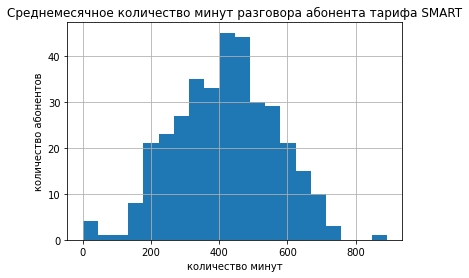

In [29]:
smart_call['call_sum_min'].hist(bins=20).set(title=
                            'Среднемесячное количество минут разговора абонента тарифа SMART', 
                             xlabel='количество минут', ylabel='количество абонентов');

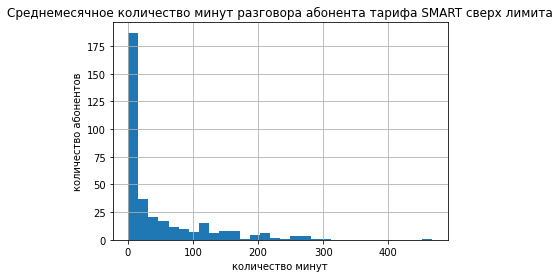

In [30]:
smart_call['call_over_limit'].hist(bins=30).set(title=
                            'Среднемесячное количество минут разговора абонента тарифа SMART сверх лимита', 
                             xlabel='количество минут', ylabel='количество абонентов');

В оплаченный пакет тарифа SMART включено 500 минут разговора, фактически значительная часть абонентов тратит в месяц  на разговоры 300-600 минут с пиком в области 420 минут +/- стандартное отклонение в 146 минут. И медиана, и среднее лежат на уровне ниже 500 пакетных минут. То есть сверхлимитного времени не так уж много, большинство стараются укладываться в "пакетное"  и доплачивают за сверхлимитные разговоры по минимуму: на гистограмме сверхлимитного времени мы видим пик около нулевой отметки.

**СМС**

Рассчитаем среднее количество смс, который пользователь тарифа тратит в месяц:

In [31]:
smart_message = total_smart.groupby(['user_id'])['message_count',
                                                 'messagе_over_limit',
                                                 ].mean()
smart_message.head()

,message_count,messagе_over_limit
user_id,,
1001,0.0,0.00
1002,10.0,0.00
1005,46.0,2.75
1006,0.0,0.00
1007,25.0,0.00


In [32]:
smart_message.describe()

,message_count,messagе_over_limit
count,351.000000,351.000000
mean,32.259907,5.862868
std,26.530803,12.310840
min,0.000000,0.000000
25%,11.000000,0.000000
50%,27.500000,0.000000
75%,48.000000,4.166667
max,118.000000,72.375000


Построим гистограмму среднемесячного количества СМС абонентов:

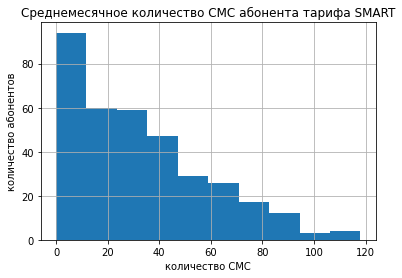

In [33]:
smart_message['message_count'].hist(bins=10).set(title=
                            'Среднемесячное количество СМС абонента тарифа SMART', 
                             xlabel='количество СМС', ylabel='количество абонентов');

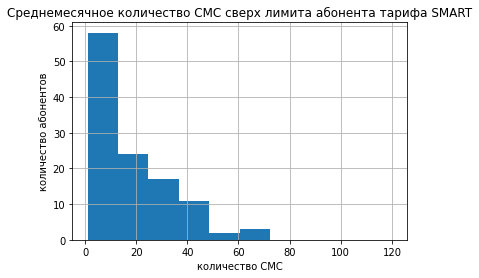

In [34]:
smart_message['messagе_over_limit'].hist(bins=10, range = (1, 120)).set(title=
                            'Среднемесячное количество СМС сверх лимита абонента тарифа SMART', 
                             xlabel='количество СМС', ylabel='количество абонентов');

Часть абонентов не пользуется СМС-сервисом, большинство не использует свой лимит в 50 сообщений полностью. Лишь у четверти абонентов есть дополнительные СМС-сообщения, при среднем перелимите в 12 сообщений стандартное отклонение составляет 12 - разброс большой и это скорее исключение, чем правило.

**Интернет-трафик**

Рассчитаем средний объем интернет-трафика, который пользователь тарифа тратит в месяц:

In [35]:
smart_traffic = total_smart.groupby(['user_id'])['mb_used',
                                                 'Gb_over_limit',
                                                 ].mean()
smart_traffic.head()

,mb_used,Gb_over_limit
user_id,,
1001,16233.000000,1.500000
1002,16576.645714,2.428571
1005,8307.275833,0.000000
1006,14926.255455,1.909091
1007,14625.074444,1.222222


In [36]:
smart_traffic.describe()

,mb_used,Gb_over_limit
count,351.000000,351.000000
mean,16134.515353,3.088877
std,3676.972553,2.679981
min,0.000000,0.000000
25%,13864.998016,0.944444
50%,16246.751429,2.500000
75%,18585.116944,4.732143
max,27286.960000,14.666667


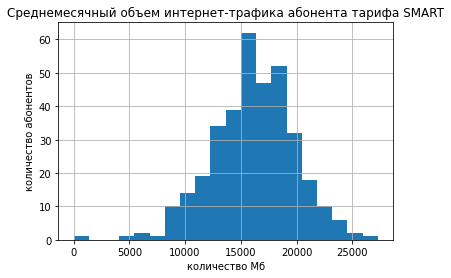

In [37]:
smart_traffic['mb_used'].hist(bins=20).set(title=
                            'Среднемесячный объем интернет-трафика абонента тарифа SMART', 
                             xlabel='количество Мб', ylabel='количество абонентов');

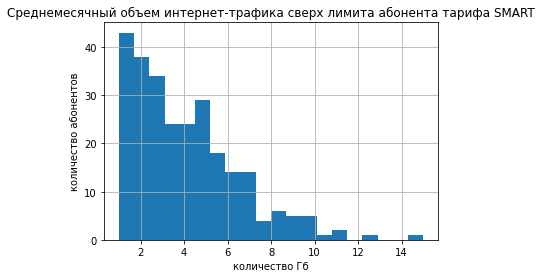

In [38]:
smart_traffic['Gb_over_limit'].hist(bins=20, range=(1,15)).set(title=
                            'Среднемесячный объем интернет-трафика сверх лимита абонента тарифа SMART', 
                             xlabel='количество Гб', ylabel='количество абонентов');

Предоплаченный трафик составляет 15 Гб, но средняя и медиана находятся на одном уровне,- чуть выше лимита и составляет около 16 Гб. То есть большинству трафика все-таки не хватает и перелимит у большей части составляет 1-3 Гб.

**Выручка**


Рассчитаем среднемесячную выручку, полученную с каждого абонента тарифа SMART и построим гистограмму:

In [39]:
smart_income = total_smart.groupby(['user_id'])['total_income'].mean().to_frame()
smart_income.head()


,total_income
user_id,
1001,850.000000
1002,1035.714286
1005,827.000000
1006,931.818182
1007,913.444444


In [40]:
smart_income['total_income'].describe()

count     351.000000
mean     1322.194749
std       606.584126
min       550.000000
25%       865.476190
50%      1176.400000
75%      1667.166667
max      4333.333333
Name: total_income, dtype: float64

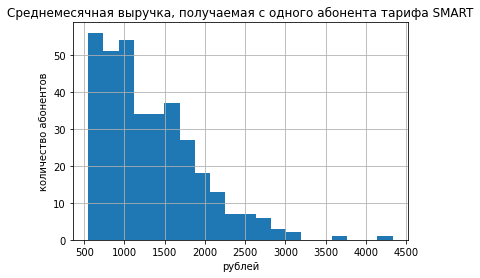

In [41]:
smart_income['total_income'].hist(bins=20).set(title=
                            'Среднемесячная выручка, получаемая с одного абонента тарифа SMART', 
                             xlabel='рублей', ylabel='количество абонентов');


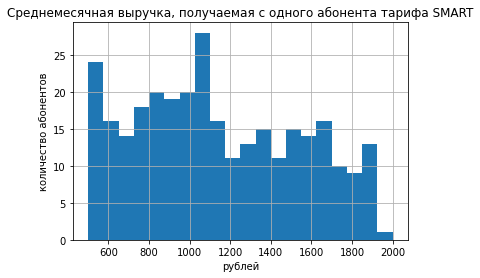

In [42]:
#ограничим диапазон ежемесячного платежа суммой до 2 тыс руб.
smart_income['total_income'].hist(bins=20, range= (500, 2000)).set(title=
                            'Среднемесячная выручка, получаемая с одного абонента тарифа SMART',
                             xlabel='рублей', ylabel='количество абонентов');


На гистограмме видно, что в целом выручка от абонентов тарифа больше абонентской платы в 550 руб., большая часть все-таки доплачивает,- в основном за сверхлимитные разговоры и интернет-трафик,  в среднем выручка составляет 1322 руб. со стандартным отклонением 606 руб.
При этом большинство платят от 800 руб. до 1,2 тыс.руб.

Рассмотрим структуру выручки от тарифа SMART. Для этого соберем выручку от отдельных позиций в единый датафрейм и построим для наглядности круговую диаграмму:

In [43]:
package_smart = len(total_smart) * 550

income_total_smart = pd.DataFrame([['calls', total_smart['call_over_limit_rub'].sum()], 
          ['message', total_smart['messagе_over_limit_rub'].sum()],
          ['internet',total_smart['Gb_over_limit_rub'].sum()],
          ['package', package_smart]])
income_total_smart.columns = ['income', 'smart']
income_total_smart = income_total_smart.set_index('income')
income_total_smart


,smart
income,
calls,278217
message,38784
internet,1332400
package,1226500


In [44]:
#общая сумма выручки
income_total_smart.sum()

smart    2875901
dtype: int64

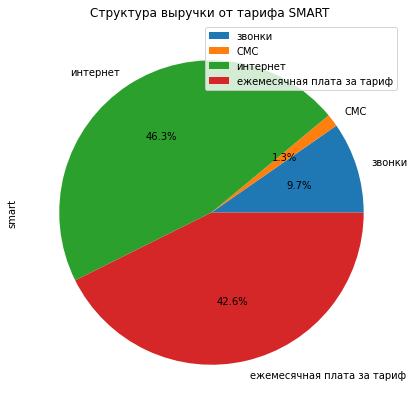

In [45]:
income_total_smart.plot(kind = 'pie', y ='smart', autopct='%1.1f%%', figsize= (7,7),
                         title = 'Структура выручки от тарифа SMART ', 
                         labels = ['звонки', 'СМС', 'интернет', 'ежемесячная плата за тариф']);

Таким образом, выручка от тарифа  SMART - это абонентская плата (42%), плата за сверхнормативный интернет (46%) и сверхнормативные звонки (почти 10%).

**Вывод**


В оплаченный пакет тарифа SMART включено 500 минут разговора, фактически значительная часть абонентов тратит в месяц на разговоры 300-600 минут с пиком в области 420 минут +/- стандартное отклонение в 146 мин. То есть сверхлимитного времени не так уж много, большинство стараются укладываться в "пакетное" и доплачивают за сверхлимитные разговоры по минимуму.

Часть абонентов не пользуется СМС-сервисом, большинство не использует свой лимит в 50 сообщений полностью. Лишь у четверти абонентов есть дополнительные СМС-сообщения и их немного.


Предоплаченный интернет-трафик составляет 15 Гб, но средняя и медиана находятся на одном уровне,- чуть выше лимита и составляет около 16 Гб. То есть большинству трафика все-таки не хватает и перелимит у большей части составляет 1-3 Гб.

Выручка от применения тарифа SMART больше абонентской платы в 550 руб., большая часть все-таки доплачивает,- в основном за сверхлимитные разговоры и интернет-трафик, и в среднем она составляет 1322 руб. со стандартным отклонением 606 руб. При этом большинство платят от 800 руб. до 1,2 тыс.руб.

В целом выручка от тарифа SMART - это абонентская плата (42%), плата за сверхнормативный интернет (46%) и сверхнормативные звонки (почти 10%).

### Тариф 'ultra'

В нашей выборке total_ultra 149 абонентов тарифа SMART. Рассчитаем среднее количество минут разговора, сообщений и объем интернет-трафика для каждого пользователя тарифа, для чего построим сводную таблицу:

**Звонки**

Рассчитаем среднее количество минут, который пользователь тарифа тратит в месяц:

In [46]:
ultra_call = total_ultra.groupby(['user_id'])['call_sum_min',
                                              'call_over_limit',
                                              ].mean()
ultra_call.head()

,call_sum_min,call_over_limit
user_id,,
1000,320.750,0.0
1003,764.400,0.0
1004,123.375,0.0
1013,468.000,0.0
1016,61.000,0.0


In [47]:
ultra_call.describe()

,call_sum_min,call_over_limit
count,149.000000,149.0
mean,524.279391,0.0
std,284.142240,0.0
min,0.000000,0.0
25%,320.750000,0.0
50%,513.333333,0.0
75%,746.333333,0.0
max,1179.363636,0.0


Построим гистограмму по средней продолжительности звонков:

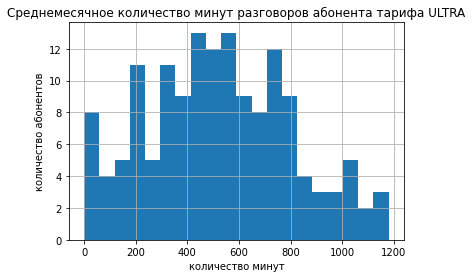

In [48]:
ultra_call['call_sum_min'].hist(bins=20).set(title=
                            'Среднемесячное количество минут разговоров абонента тарифа ULTRA', 
                             xlabel='количество минут', ylabel='количество абонентов');

В оплаченный пакет тарифа ultra включено 3000 минут разговора, но ни один из абонентов не потратил свой лимит полностью: значительная часть абонентов тратит в месяц на разговоры 300-800 минут с пиком в области 520 минут +/- стандартное отклонение в 284 мин. Это немного больше , чем в smart- и общей продолжительностью, и разбросом значений, но с таким предоплаченным количеством минут можно себе это позволить, т.к. неиспользованное время все-равно остается.

Медиана практически на одном уровне со средним и можно говорить о нормальном распределении.

**СМС**

Рассчитаем среднее количество смс, который пользователь тарифа тратит в месяц:

In [49]:
ultra_message = total_ultra.groupby(['user_id'])['message_count',
                                                 'messagе_over_limit',
                                                 ].mean()
ultra_message.head()

,message_count,messagе_over_limit
user_id,,
1000,62.0,0.0
1003,76.0,0.0
1004,149.0,0.0
1013,21.0,0.0
1016,71.0,0.0


In [50]:
ultra_message.describe()

,message_count,messagе_over_limit
count,149.000000,149.0
mean,53.668121,0.0
std,46.420854,0.0
min,0.000000,0.0
25%,14.000000,0.0
50%,45.000000,0.0
75%,84.000000,0.0
max,192.000000,0.0


Построим гистограмму среднемесячного количества СМС абонентов:

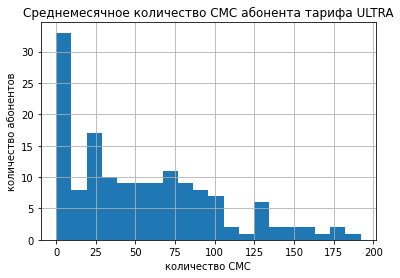

In [51]:
ultra_message['message_count'].hist(bins=20).set(title=
                            'Среднемесячное количество СМС абонента тарифа ULTRA', 
                             xlabel='количество СМС', ylabel='количество абонентов');

Как видим, включенные в пакет 1000 СМС-сообщений никто не использует полностью, максимум- это 192 сообщения, многие не используют СМС-сервис либо используют его по минимуму. В среднем -53 СМСки, при медиане в 45, то есть можно говорить о нормальном распределении с чуть растянутым хвостом вправо.

**Интернет-трафик**

Рассчитаем средний объем интернет-трафика, который пользователь тарифа тратит в месяц:

In [52]:
ultra_traffic = total_ultra.groupby(['user_id'])['mb_used',
                                                 'Gb_over_limit',
                                                 ].mean()
ultra_traffic.head()

,mb_used,Gb_over_limit
user_id,,
1000,13424.03875,0.0
1003,11456.12800,0.0
1004,18629.93500,0.0
1013,15258.58000,0.0
1016,13405.22000,0.0


In [53]:
ultra_traffic.describe()

,mb_used,Gb_over_limit
count,149.000000,149.000000
mean,19443.271135,0.903659
std,8436.860129,1.984883
min,0.000000,0.000000
25%,13550.778182,0.000000
50%,18685.458000,0.000000
75%,25801.390000,0.250000
max,38463.570000,8.500000


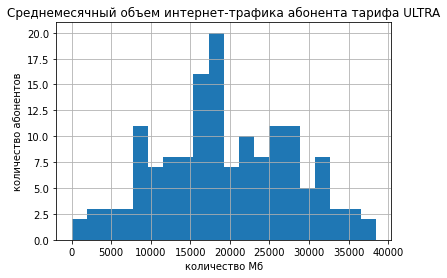

In [54]:
ultra_traffic['mb_used'].hist(bins=20).set(title=
                            'Среднемесячный объем интернет-трафика абонента тарифа ULTRA', 
                             xlabel='количество Мб', ylabel='количество абонентов');

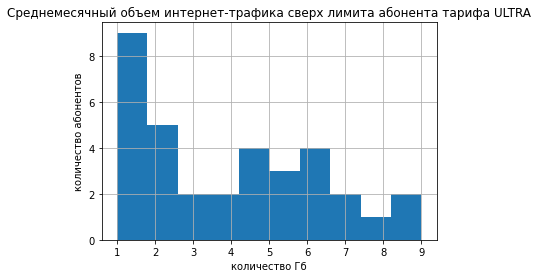

In [55]:
ultra_traffic['Gb_over_limit'].hist(bins=10, range = (1,9)).set(title=
                            'Среднемесячный объем интернет-трафика сверх лимита абонента тарифа ULTRA', 
                             xlabel='количество Гб', ylabel='количество абонентов');

Пользователи тарифа, имея 30 Гб пакетного интернет-трафика, в основном его и тратят. Не выходит за его пределы более 3/4 пользователей, среднее и медиана находятся практически в одном диапазоне -16-19 Гб, при этом стандартное отклонение достаточно большое (8 Гб).При этом кто-то совсем не пользуется пакетным интернетом, а кто-то использует 38 Гб, и это максимум.

**Выручка**

Посчитаем среднюю выручку абонентов тарифа ULTRA:

In [56]:
ultra_income = total_ultra.groupby(['user_id'])['total_income'].mean().to_frame()
ultra_income.head()


,total_income
user_id,
1000,1950.0
1003,1950.0
1004,1950.0
1013,1950.0
1016,1950.0


In [57]:
ultra_income.describe()

,total_income
count,149.000000
mean,2085.548788
std,297.732421
min,1950.000000
25%,1950.000000
50%,1950.000000
75%,1987.500000
max,3225.000000


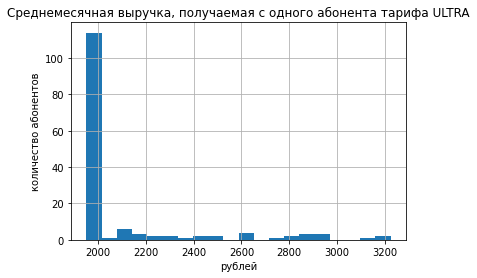

In [58]:
ultra_income['total_income'].hist(bins=20).set(title=
                            'Среднемесячная выручка, получаемая с одного абонента тарифа ULTRA', 
                             xlabel='рублей', ylabel='количество абонентов');


В подавляющем большинстве случаев выручка от использования тарифа (3/4 от количества абонентов) - это абонентская плата. Стандартное отклонение это также может подтвердить - оно составляет всего 297 руб. Доплаты делают только те клиенты, которым не хватает интернет-трафика, максимально это 3225 руб.

Рассмотрим структуру выручки от тарифа SMART. Для этого соберем выручку от отдельных позиций в единый датафрейм и построим для наглядности круговую диаграмму:

In [59]:
package_cost_ultra = len(total_ultra) * 1950

income_total_ultra = pd.DataFrame([['calls', total_ultra['call_over_limit_rub'].sum()], 
          ['message', total_ultra['messagе_over_limit_rub'].sum()],
          ['internet',total_ultra['Gb_over_limit_rub'].sum()],
          ['package', package_cost_ultra]])
income_total_ultra.columns = ['income', 'ultra']
income_total_ultra = income_total_ultra.set_index('income')
income_total_ultra

,ultra
income,
calls,0
message,0
internet,118350
package,1922700


In [60]:
#Общая сумма дохода, полученная от использования тарифа ULTRA 
income_total_ultra.sum()

ultra    2041050
dtype: int64

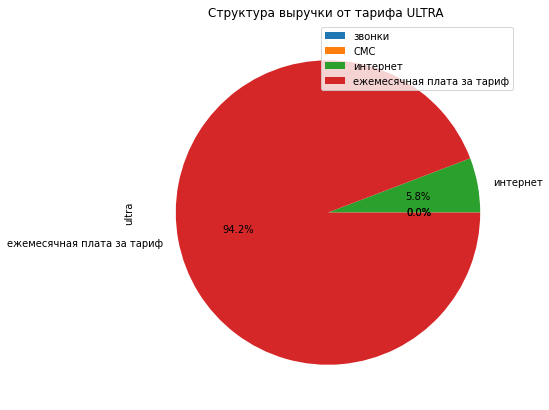

In [61]:
income_total_ultra.plot(kind = 'pie', y ='ultra', autopct='%1.1f%%', figsize= (7,7),
                         title = 'Структура выручки от тарифа ULTRA ',
                         labels = ['звонки', 'СМС', 'интернет', 'ежемесячная плата за тариф']);
plt.show()


Таким образом, тариф ULTRA , в основном , это фиксированная сумма платежа, известная заранее, (94%)  плюс плата за сверхлимитный интернет (5,8%). Такой тариф более предсказуем в части финансового планирования и единственное, что может изменить запланированную сумму выручки- это отток клиентов. 

**Вывод**


В оплаченный пакет тарифа ultra включено 3000 минут разговора, но ни один из абонентов не потратил свой лимит полностью: значительная часть абонентов тратит в месяц на разговоры 300-800 минут с пиком в области 520 минут +/- стандартное отклонение в 284 мин. Это немного больше , чем в smart- и общей продолжительностью, и разбросом значений, но с таким предоплаченным количеством минут можно себе это позволить, т.к. неиспользованное время все-равно остается.


Включенные в пакет 1000 СМС-сообщений никто не использует полностью, максимум- это 192 сообщения, многие не используют СМС-сервис либо используют его по минимуму. 


Пользователи тарифа, имея 30 Гб пакетного интернет-трафика, в основном его и тратят. Не выходит за его пределы более 3/4 пользователей. При этом кто-то совсем не пользуется пакетным интернетом, а кто-то использует 38 Гб, и это максимум.


В подавляющем большинстве случаев выручка от использования тарифа (3/4 от количества абонентов) - это абонентская плата. Доплаты делают только те клиенты, которым не хватает интернет-трафика, максимально это 3225 руб.

Таким образом, тариф ULTRA , в основном,- это фиксированная сумма платежа, известная заранее, (94%) плюс плата за сверхлимитный интернет (5,8%). 


### Вывод по разделу 4.1.


Абоненты тарифа smart используют в среднем 420 минут разговора (+/- 146) при включенных в пакет 500 минутах, а доплата за сверхнормативное время в целом небольшая. В то же время абоненты тарифа ultra, при пакете размером 3000 минут, в среднем разговаривают 520 (+/- 284) минуты, то есть всего на 100 минут больше , чем абоненты smart, и такой объем несопоставим с их предоплаченными минутами.

СМС-сервисом не пользуются активно в обоих тарифах : это в среднем 30 СМС у smart и 53 у ultra. И снова отметим большой предоплаченный пакет ultra, - 1000 СМС-сообщений.

Среднемесячный интернет-трафик у абонентов smart составляет в среднем 16 Gb, и перелимит (сверх пакетных 15 Gb) у большей части составляет 1-3 Gb. При этом пользователи ultra, имея 30 Гб пакетного интернет-трафика, в основном его и тратят, не выходя за пределы пакетных 30 Gb. При этом кто-то совсем не пользуется пакетным интернетом, а кто-то использует 38 Гб, и это максимум.


Выручка от использования тарифа SMART больше абонентской платы в 550 руб., т.е. большая часть абонентов все-таки доплачивает,- в основном за сверхлимитные разговоры и интернет-трафик, и в среднем она составляет 1322 руб. со стандартным отклонением 606 руб. При этом большинство платит от 800 руб. до 1,2 тыс.руб.
А вот выручка от использования тарифа ULTRA в подавляющем большинстве случаев- это абонентская плата, доплаты делают только те клиенты, которым не хватает интернет-трафика. В среднем абонент ULTRA платит около 2 тыс.руб. в месяц. 




## Проверка гипотез

Для проверки гипотез сравним данные двух выборок со среднемесячной выручкой абонентов, которые сохранены в переменных smart_income и ultra_income.

Для анализа будем использовать t-критерий Стьюдента, поскольку сравниваемые выборки независимы между собой.


###  - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
         

**Сформулируем гипотезы:**

* Н0: выручка пользователей тарифов smart и ultra не различается 
* Н1: выручка пользователей тарифов smart и ultra различается


Перед проведением теста проведем подготовку данных, а именно -удалим выбросы данных межквартильным методом (IQR-методом):

In [62]:
total_smart = total_smart.set_index('user_id')
total_ultra = total_ultra.set_index('user_id')
total_smart

,month,call_count,call_sum_min,message_count,mb_used,tariff,call_over_limit,call_over_limit_rub,messagе_over_limit,messagе_over_limit_rub,Gb_over_limit,Gb_over_limit_rub,total_income
user_id,,,,,,,,,,,,,
1001,11,45,430,0,18429.34,smart,0,0,0,0,3,600,1150
1001,12,47,414,0,14036.66,smart,0,0,0,0,0,0,550
1002,6,14,117,4,10856.82,smart,0,0,0,0,0,0,550
1002,7,21,214,11,17580.10,smart,0,0,0,0,3,600,1150
1002,8,37,289,13,20319.26,smart,0,0,0,0,5,1000,1550
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,9,0,0,32,17206.30,smart,0,0,0,0,2,400,950
1489,10,0,0,21,19559.44,smart,0,0,0,0,5,1000,1550
1489,11,0,0,20,17491.56,smart,0,0,0,0,3,600,1150


In [63]:
def delete_blowouts(df, column):
    q1 = df[column].quantile(0.25) 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    print('выбросы до:', q1 - 1.5 * iqr, 'от:', q3 + 1.5 * iqr)
    iqr_test = (df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))
    return df.loc[iqr_test]

In [64]:
print('количество значений до удаления выбросов:', total_smart['total_income'].count())

#применяем функцию delete_blowouts для удаления выбросов 
smart_test = delete_blowouts(total_smart, 'total_income')

print('количество значений после удаления выбросов:', smart_test['total_income'].count())


количество значений до удаления выбросов: 2230
выбросы до: -1250.0 от: 3550.0
количество значений после удаления выбросов: 2199


In [65]:
print('количество значений до удаления выбросов:', total_ultra['total_income'].count())

#применяем функцию delete_blowouts для удаления выбросов['total_income']
ultra_test = delete_blowouts(total_ultra, 'total_income')

print('количество значений после удаления выбросов:', ultra_test['total_income'].count())


количество значений до удаления выбросов: 986
выбросы до: 1950.0 от: 1950.0
количество значений после удаления выбросов: 852


Как можно заметить, в данных тарифов как выбросы были удалены только "правые" хвосты- со значениями значительно больше, чем основная часть выборки. Рассчитанные значения "слева" оказались меньше, чем минимальные значения выручки.

**Проведем t-test по очищенным от выбросов выборок:**

In [66]:
alpha = 0.05
results = st.ttest_ind(ultra_test['total_income'], smart_test['total_income'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.1080242236586082e-155
Отвергаем нулевую гипотезу


Разница не случайна, есть значимые различия между выборками, следовательно средняя выручка тарифов отличается.

Посмотрим на отличия:

Общая сумма выручки от применения тарифов smart и ultra в рублях за весь период (2018 год): 

In [67]:
income_total = income_total_smart.join(income_total_ultra)
income_total

,smart,ultra
income,,
calls,278217,0
message,38784,0
internet,1332400,118350
package,1226500,1922700


['звонки', 'сообщения', 'интернет', 'пакет']


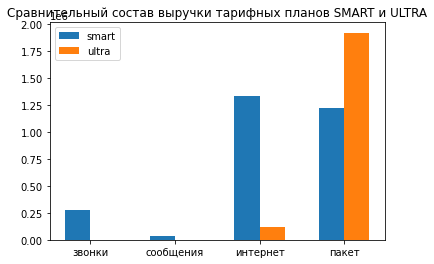

In [68]:
cat_par = ['звонки', 'сообщения', 'интернет', 'пакет']

print(cat_par)
g1 = income_total['smart']
g2 = income_total['ultra']
width = 0.3
x = np.arange(len(cat_par))
fig, ax = plt.subplots();
rects1 = ax.bar(x - width/2, g1, width, label='smart')
rects2 = ax.bar(x + width/2, g2, width, label='ultra')
ax.set_title('Сравнительный состав выручки тарифных планов SMART и ULTRA')
ax.set_xticks(x)
ax.set_xticklabels(cat_par)
ax.legend()
plt.show()

Для наглядности:

smart    2875901
ultra    2041050
dtype: int64


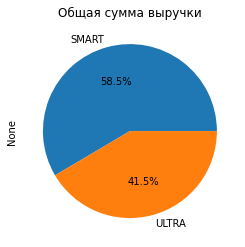

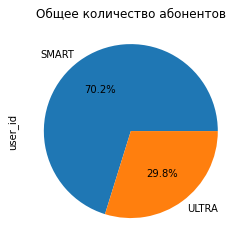

In [69]:
#общая сумма выручки
print(income_total.sum(axis=0))
income_total.sum(axis=0).plot(kind = 'pie', y ='income', autopct='%1.1f%%', 
                         title = 'Общая сумма выручки',
                         labels = ['SMART', 'ULTRA']);
plt.show()

#общее количество абонентов

users_count = users.groupby('tariff')['user_id'].count()
users_count.plot(kind = 'pie', y ='sum', autopct='%1.1f%%', 
                         title = 'Общее количество абонентов',
                         labels = ['SMART', 'ULTRA']);


Мы подтвердили нашу гипотезу и сделанные ранее выводы , что в целом у тарифа smart меньшая плата за предоплаченный пакет, но она компенсируется доплатами за сверхлимитный интернет-трафик звонки, в отличие от ultra, основную часть выручки которого составляет абонентская плата и незначительная по сравнению  с ней выручка от оплаты сверхнормативного интернет-трафика. В ultra большинство не используют значительную часть предоставленных минут разговора и интернет-трафика, то есть для клиента он не так выгоден и не так популярен, как smart, что может стать причиной оттока абонентов ultra.

Посмотрим на динамику заключения/расторжения договоров абонентов:

In [70]:
# выборка количества зарегистрированных и расторгнутых договоров
users_count = users.groupby('tariff')['reg_date','churn_date'].count()
users_count['churn_%'] = users_count['churn_date']/users_count['reg_date']
users_count

,reg_date,churn_date,churn_%
tariff,,,
smart,351,23,0.065527
ultra,149,15,0.100671


Как видим, у тарифа ultra количество заключивших договор в течение года в 2 раза меньше, но расторгнувших его в последствии -10%, тогда как пользователей тарифа smart ,соответственно, в 2 раза больше, но отток при этом меньше, всего 6%.

**Вывод**


Гипотеза,  что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются, не опровергнута. 

В целом у тарифа smart меньшая плата за предоплаченный пакет, но она компенсируется доплатами за сверхлимитный интернет-трафик звонки, в отличие от ultra, основную часть выручки которого составляет абонентская плата и незначительная по сравнению с ней выручка от оплаты сверхнормативного интернет-трафика. В ultra большинство не используют значительную часть предоставленных минут разговора и интернет-трафика, то есть для клиента он не так выгоден и не так популярен, как smart, что может стать причиной оттока абонентов ultra (отток в представленной выборке составляет 10% против 6% у абонентов smart)

### Средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.


Проверим гипотезу, что средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов. Для анализа также будем использовать t-критерий Стьюдента, поскольку сравниваемые выборки- те же.

**Сформулируем гипотезы:**

- Н0: средняя выручка пользователи из Москвы не отличается от выручки пользователей из других регионов
- Н1: средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов


Данные по размеру среднемесячной выручки, полученной от каждого клиента тарифа, возьмем из очищенных выше от выбросов выборок  smart_test и ultra_test.

Для начала поделим выборки по признаку "Москва" - "не Москва":

In [71]:
#добавим колонку с городом
smart_test = (smart_test.reset_index()).merge(users[['user_id', 'city']], on='user_id', how = 'inner')

ultra_test = (ultra_test.reset_index()).merge(users[['user_id', 'city']], on='user_id', how = 'inner')


In [72]:
#сохраним выборки по критериям "Москва" -"Провинция"
moscow = smart_test.merge(ultra_test, how = 'outer').query('city == "Москва"')
moscow.head()

,user_id,month,call_count,call_sum_min,message_count,mb_used,tariff,call_over_limit,call_over_limit_rub,messagе_over_limit,messagе_over_limit_rub,Gb_over_limit,Gb_over_limit_rub,total_income,city
0,1001,11,45,430,0,18429.34,smart,0,0,0,0,3,600,1150,Москва
1,1001,12,47,414,0,14036.66,smart,0,0,0,0,0,0,550,Москва
32,1007,4,21,198,11,8022.76,smart,0,0,0,0,0,0,550,Москва
33,1007,5,57,480,39,17687.27,smart,0,0,0,0,3,600,1150,Москва
34,1007,6,55,545,26,13654.52,smart,45,135,0,0,0,0,685,Москва


In [73]:
province = smart_test.merge(ultra_test, how = 'outer').query('city != "Москва"')
province.head()

,user_id,month,call_count,call_sum_min,message_count,mb_used,tariff,call_over_limit,call_over_limit_rub,messagе_over_limit,messagе_over_limit_rub,Gb_over_limit,Gb_over_limit_rub,total_income,city
2,1002,6,14,117,4,10856.82,smart,0,0,0,0,0,0,550,Стерлитамак
3,1002,7,21,214,11,17580.10,smart,0,0,0,0,3,600,1150,Стерлитамак
4,1002,8,37,289,13,20319.26,smart,0,0,0,0,5,1000,1550,Стерлитамак
5,1002,9,25,206,4,16691.08,smart,0,0,0,0,2,400,950,Стерлитамак
6,1002,10,24,212,10,13888.25,smart,0,0,0,0,0,0,550,Стерлитамак


**Проведем t-test по полученным выборкам moscow и province:**

In [74]:
alpha = 0.05
results = st.ttest_ind(moscow['total_income'], province['total_income'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.48568922870048425
Не получилось отвергнуть нулевую гипотезу


С вероятностью в 48% такой результат может быть получен случайно. Это слишком большое значение, которое гораздо больше установленного нами уровня значимости. Следовательно, значимых различий между пользователями Москвы и регионов нет.

**Вывод**


Гипотеза,  что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, не подтвердилась. Пользователи везде ведут себя одинаково.

## Вывод по разделу 4

Абоненты тарифа smart используют в среднем 420 минут разговора (+/- 146) при включенных в пакет 500 минутах, а доплата за сверхнормативное время в целом небольшая. В то же время абоненты тарифа ultra, при пакете размером 3000 минут, в среднем разговаривают 520 (+/- 284) минуты, то есть всего на 100 минут больше , чем абоненты smart, и такой объем несопоставим с их предоплаченными минутами.

СМС-сервисом не пользуются активно в обоих тарифах : это в среднем 30 СМС у smart и 53 у ultra. И снова отметим большой предоплаченный пакет ultra, - 1000 СМС-сообщений.

Среднемесячный интернет-трафик у абонентов smart составляет в среднем 16 Gb, и перелимит (сверх пакетных 15 Gb) у большей части составляет 1-3 Gb. При этом пользователи ultra, имея 30 Гб пакетного интернет-трафика, в основном его и тратят, не выходя за пределы пакетных 30 Gb. При этом кто-то совсем не пользуется пакетным интернетом, а кто-то использует 38 Гб, и это максимум.

Выручка от использования тарифа SMART больше абонентской платы в 550 руб., т.е. большая часть абонентов все-таки доплачивает,- в основном за сверхлимитные разговоры и интернет-трафик, и в среднем она составляет 1322 руб. со стандартным отклонением 606 руб. При этом большинство платит от 800 руб. до 1,2 тыс.руб. А вот выручка от использования тарифа ULTRA в подавляющем большинстве случаев- это абонентская плата, доплаты делают только те клиенты, которым не хватает интернет-трафика. В среднем абонент ULTRA платит около 2 тыс.руб. в месяц.


Результаты проверки гипотез:

- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

- Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Пользователи везде ведут себя одинаково.

# Общий вывод

Представленные для анализа данные содержали информацию о 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.


В процессе предварительной обработки данных данные нескольких столбцов , содержащих даты, были приведены к формату datetime. 


Для дальнейшего анализа в разрезе каждого клиента помесячно были рассчитаны количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений, объем израсходованного интернет-трафика и помесячная выручка.


Исследование показало, что абоненты тарифа SMART используют примерно на 100 минут в месяц меньше времени для разговора, чем абоненты тарифа ULTRA, и при небольшой абонентской плате в 550 рублей предпочитают доплатить за излишки и не платить  1950 руб.за полный пакет в 3000 минут, как это делают абоненты ULTRA. В то же время абоненты ULTRA в большинстве не используют лимитное время пакета, и , следовательно, переплачивают.  

СМС-сервисом не пользуются активно в обоих тарифах, и снова отметим большой предоплаченный пакет ULTRA, который остается неиспользованным.

Наиболее популярной у абонентов обоих тарифов является услуга по предоставлению интернет-трафика. При этом абоненты SMART используют в среднем на 1-3 Gb больше, чем предоплачено в пакете (16-18 Gb), а пользователи ULTRA, имея 30 Гб пакетного интернет-трафика, в основном его и тратят, не выходя за пределы пакета, в среднем это 18-19 Gb в месяц. 

Выручка от использования тарифа SMART больше абонентской платы в 550 руб., т.е. большая часть абонентов все-таки доплачивает,- в основном за сверхлимитные разговоры и интернет-трафик, и в среднем она составляет 1322 руб.  А вот выручка от использования тарифа ULTRA в подавляющем большинстве случаев- это абонентская плата, доплаты делают только те клиенты, которым не хватает интернет-трафика. В среднем абонент ULTRA платит около 2 тыс.руб. в месяц.


В целом выручка от тарифа SMART - это абонентская плата (42%), плата за сверхнормативный интернет (46%) и сверхнормативные звонки (почти 10%). Выручка от тарифа ULTRA , в основном,- это фиксированная сумма платежа, известная заранее, (94%) плюс плата за сверхлимитный интернет (5,8%).

В процессе проверки гипотез при помощи t-теста Стьюдента  мы также подтвердили то, что выручка пользователей тарифов ULTRA и SMART различаются, а средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Пользователи везде ведут себя одинаково.

Поскольку абоненты ULTRA в большинстве своем не используют значительную часть предоставленных минут разговора и интернет-трафика, можно сделать вывод, что финансовое планирование оператора сотовой связи, с точки зрения понятной заранее суммы абонентской платы тарифа ULTRA, выглядит более привлекательно, чем сумма выручки от применения тарифа SMART. Но для клиента этот тариф не так выгоден и не так популярен, что может стать причиной оттока абонентов ULTRA (отток в представленной выборке составляет 10% против 6% у абонентов SMART). Поэтому  в целом можно дать рекомендацию бизнесу о рассмотрении вопроса о некотором снижении абонентской платы тарифа ULTRA с одновременным снижением небольшого количества предоплаченных услуг, что может способствовать росту абонентов данного тарифа.

